# Project Machine Learning LELEC2870

## Import 


### Packages

In [90]:
#pip install imblear
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from imblearn.over_sampling import SMOTENC
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_score, roc_curve, auc, roc_auc_score
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import linear_model

## Scoring


In [47]:
# bmi calculator 
def get_bmi(w, h):
    return w/h**2


# RMSE calculator  
def compute_rmse(predict, target):
        # SOLUTION
    if len(target.shape) == 2:
        target = target.squeeze()
    if len(predict.shape) == 2:
        predict = predict.squeeze()
    diff = target - predict
    if len(diff.shape) == 1:
        diff = np.expand_dims(diff, axis=-1)
    rmse = np.sqrt(diff.T@diff / diff.shape[0])
    return float(rmse)

def score_weight_class(bmi_pred, bmi_true, low, high):
    tol = 1
    vpred = (bmi_pred>=low-tol) & (bmi_pred<high+tol)
    vtrue = (bmi_true>=low) & (bmi_true<high)
    if vtrue.sum()==0:
        print("no true sample here")
        return 0
    
    rmse = np.sqrt(((bmi_true[vtrue]-bmi_pred[vtrue])**2).mean())
    rmse = rmse/(high-low+tol)
    acc = (vpred&vtrue).sum()/vtrue.sum()
    return rmse*(1-acc)


def score_regression(ytrue, ypred, height):
    bmi_pred = ypred/(height*height)
    bmi_true = ytrue/(height*height)

    score = []
    for bmi_low, bmi_high in zip([0,18.5,25,30],[18.5, 25, 30, 100]):
        score.append(score_weight_class(bmi_pred, bmi_true, low = bmi_low, high = bmi_high))
        return np.mean(score)


def mybmi(X,y) :
    # Retourne un dataframe avec un colonne nommée bmi reprenant le bmi de chaque individu 
    return pd.DataFrame(y/(X**2))#, columns =["bmi"])

## ROC curve 
def plot_roc_curve(Y_test, Y_pred, model_probs, title='Roc-curve'):
 
   random_probs = [0 for _ in range(len(Y_test))]
   # calculate AUC
   model_auc = roc_auc_score(Y_test, model_probs)
   # print sensitiity 
   print(precision_score(Y_test, Y_pred))
   # calculate ROC Curve
      # For the Random Model
   random_fpr, random_tpr, _ = roc_curve(Y_test, random_probs)
      # For the actual model
   model_fpr, model_tpr, _ = roc_curve(Y_test, model_probs)
   # Plot the roc curve for the model and the random model line
   plt.plot(random_fpr, random_tpr, linestyle='--', label='Random')
   plt.plot(model_fpr, model_tpr, marker='.', label='Model')
   # Create labels for the axis
   plt.xlabel('False Positive Rate')
   plt.ylabel('True Positive Rate')
   # show the legend
   plt.legend()
   # show title
   plt.title(title+' || AUC=%.3f' % (model_auc))
   # show the plot
   plt.show()


### Data

In [48]:
# X1, Y1
X_1 = pd.read_csv('X1.csv')
y_1 = pd.read_csv('Y1.csv', header=None)
y_1.columns = ["target"]
y_1 = y_1.values.ravel()

#X2, Y2
X_2 = pd.read_csv('X2.csv')


## Data Exploratory Analysis 

### valid data set check 

In [49]:
# check wether dataset contains null values
print(X_1[["Age", "Height"]].isnull().sum())

# check wether dataset contains missing values
#X_1.dropna()

#print(X_1.count())

Age       0
Height    0
dtype: int64


-> No null or missing observations for continuous variables

### continuous variables 

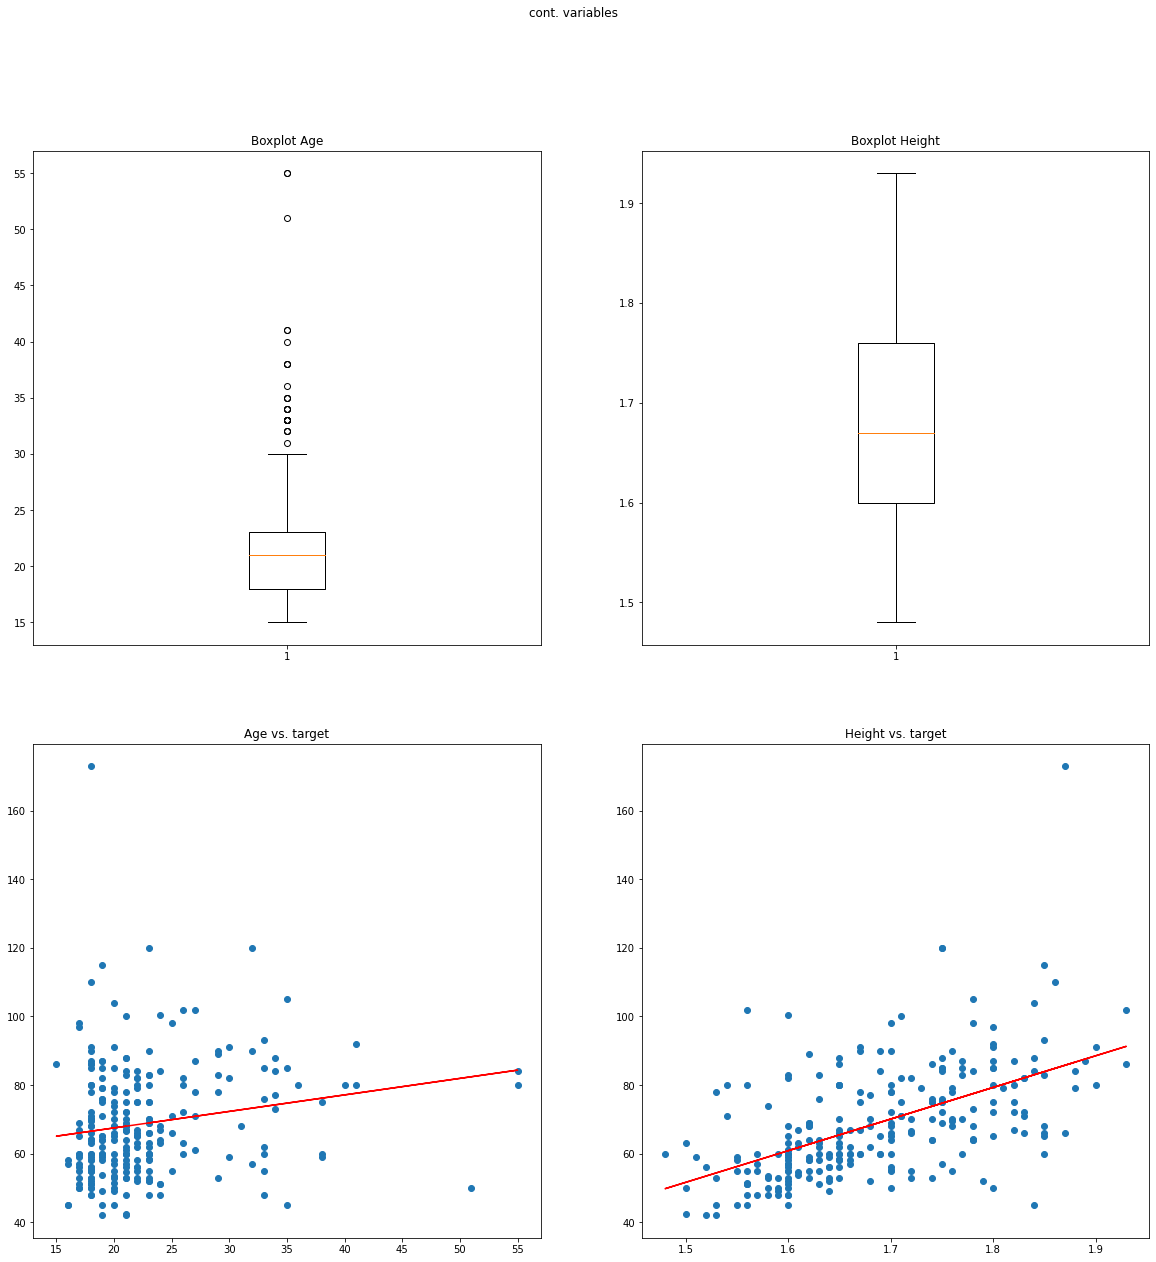

In [50]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.suptitle("cont. variables")

axes[0,0].boxplot(X_1["Age"])
axes[0,0].set_title('Boxplot Age')
axes[0,1].boxplot(X_1["Height"])
axes[0,1].set_title('Boxplot Height')

""" linearity between cont. var and target var """

# scat_plot_1
x = X_1['Age']
y = y_1

stats = linregress(x, y)

m = stats.slope
b = stats.intercept

axes[1,0].scatter(x, y)
axes[1,0].plot(x, m * x + b, color='red')
axes[1,0].set_title('Age vs. target')

# scat_plot_2
x = X_1['Height']
y = y_1

stats = linregress(x, y)

m = stats.slope
b = stats.intercept

axes[1,1].scatter(x, y)
axes[1,1].plot(x, m * x + b, color='red')
axes[1,1].set_title('Height vs. target')

plt.rcParams['figure.figsize'] = (10, 10)
plt.show()





$\bold{Age}$ is highly skewed, might be a problem for linreg later on whereas, $\bold{Height}$ seems to have no outliers

In [51]:
# missing values for categorical variables 
print(X_1[['Gender', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 
'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS']].isnull().sum())
# no missing values

Gender                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
dtype: int64


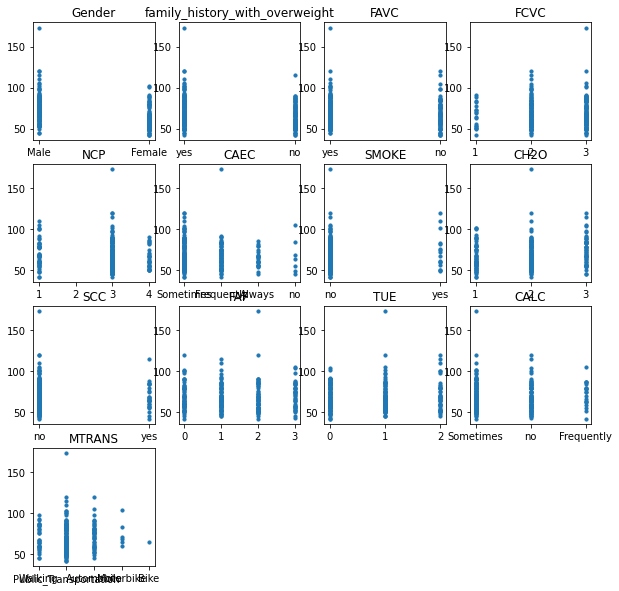

In [52]:
var_names = ['Gender', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 
'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS']
n_feats = len(var_names)
# 15 features

for i, var in enumerate(var_names):
    plt.subplot((n_feats//4+1), 4, i+1)
    plt.scatter(X_1[var], y_1, s=10)
    plt.title(var_names[i])

plt.rcParams['figure.figsize'] = (20, 20)
plt.tight_layout
plt.show()




E.G. MTRANS, aggréger des classes genre velo + à pied = sport/pas moteur

We need to pay attention to the fact that all the categories are not well balanced. i.e, there are way less non-smoker than smoker in the study 



## Data Cleaning

### Categorial variables

In [53]:
def clean_categorical(data, choice) :

                # Data Cleaning :
                # Je modifie les variable catégorielle sous forme de nombre en mots compréhensibles, c'est mieux pour la suite

                # Création du dictionnaire
                dummies_dict = {"FCVC": {1.0: "Never", 2.0: "Sometimes", 3.0: "Always"},
                                "NCP": {1.0: "Betw1_2", 2.0: "Three", 3.0: "Tree++"},
                                "CH2O": {1.0: "Less1L", 2.0: "Betw1_2", 3.0: "Two++"},
                                "FAF": {1.0: "no_acti", 2.0: "1_2Day", 3.0: "2_4Day", 4.0: "4_5Day"},
                                "TUE": {1.0: "0_2hour", 2.0: "3_5hour", 3.0: "Five++"}}

                # Remplacement dans le dataframe
                new_X = data.replace(dummies_dict)

                # Binarized categorical variables
                X_cleaned = pd.get_dummies(new_X,
                                                columns=["Gender", "family_history_with_overweight", "FAVC", "FCVC", "NCP", "CAEC",
                                                        "SMOKE", "CH2O", "SCC", "FAF", "TUE", "CALC", "MTRANS"],
                                                prefix=["Gender", "family_history_with_overweight", "FAVC", "FCVC", "NCP", "CAEC",
                                                        "SMOKE", "CH2O", "SCC", "FAF", "TUE", "CALC", "MTRANS"], )#drop_first=True)
        
                

                if (choice ==1) :
                        X_return = X_cleaned.drop(columns=['Gender_Male', 'family_history_with_overweight_no', 'FAVC_no', 'SMOKE_no', 'SCC_no'])
                        return X_return

                elif(choice == 2) :
                        
                        X_return = X_cleaned.drop(columns=['CALC_Always', 'Gender_Male', 'family_history_with_overweight_no', 'FAVC_no', 'SMOKE_no', 'SCC_no'])
                        return X_return




    

In [54]:
X_1_cleaned = clean_categorical(X_1, 1)
X_2_cleaned = clean_categorical(X_2, 2)

### Countinuous variables

In [55]:
def scale_data(data, scaler):

    changed_data = data.copy()

    if scaler == "MinMax" :
        method = MinMaxScaler()
    elif scaler == "Standard" :
        method = StandardScaler()
    
    changed_data[['Age', 'Height']] = method.fit_transform(changed_data[['Age', 'Height']])
    changed_data = changed_data.iloc[: , 1:]

    return changed_data




In [56]:
X1_cleaned_scale = scale_data(X_1_cleaned, "MinMax")
X1_cleaned_scale

,Age,Height,Gender_Female,family_history_with_overweight_yes,FAVC_yes,FCVC_Always,FCVC_Never,FCVC_Sometimes,NCP_4.0,NCP_Betw1_2,...,TUE_0_2hour,TUE_3_5hour,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Automobile,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,0.150,0.888889,0,1,1,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
1,0.100,0.488889,0,1,1,0,0,1,0,1,...,0,0,0,1,0,0,0,0,1,0
2,0.075,0.844444,0,1,1,0,0,1,0,1,...,0,1,0,1,0,0,0,0,1,0
3,0.150,0.288889,1,1,1,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
4,0.175,0.288889,1,1,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.175,0.444444,1,0,1,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
246,0.200,0.377778,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
247,0.075,0.266667,1,1,1,1,0,0,0,1,...,0,1,0,0,1,0,0,0,0,1
248,0.525,0.377778,1,1,1,0,0,1,0,0,...,0,1,0,0,1,1,0,0,0,0


For the sake of classification we need to get catgorical variables to target. Hence, we compute the bmi of each obs in Y_1 to train the KNN model. 
We use it as well for MLP 

In [57]:
print(X_1.shape)

(250, 16)


### Generate variable BMI in continuous and categorical way

In [58]:
# BMI CONTINU
bmi = mybmi(X_1["Height"],y_1)
bmi_continu = bmi

# On catégorise avec label 0,1,2,3
bmi = pd.cut(bmi_continu["Height"], bins=[0, 18.5, 25, 30, 100], labels=[0,1,2,3])
#bmi = bmi.values.ravel()

### Increasing sample size

 SMOTE and ADASYN generate new samples in by interpolation. However, the samples used to interpolate/generate new synthetic samples differ. In fact, ADASYN focuses on generating samples next to the original samples which are wrongly classified using a k-Nearest Neighbors classifier while the basic implementation of SMOTE will not make any distinction between easy and hard samples to be classified using the nearest neighbors rule. Therefore, the decision function found during training will be different among the algorithms.


#### Find optimal K using KNeighborsMixin

In [59]:
def find_k_optimal(data, target_variable, low_k, high_k, step) :

    # drop NA
    Choice_K_dataset = data.dropna()

    # Generate test and train set with shuffle = TRUE
    train_set , test_set = train_test_split(Choice_K_dataset, test_size = 0.3, shuffle=True)

    # Generate x and y
    x_train = train_set.drop(target_variable, axis=1)
    y_train = train_set[target_variable]

    x_test = test_set.drop(target_variable, axis=1)
    y_test = test_set[target_variable]


    rmse_val = {} #to store rmse values for different k
    for K in range(low_k, high_k, step):
        
        model = KNeighborsClassifier(n_neighbors = K)
        model.fit(x_train, y_train)  #fit the model
        pred=model.predict(x_test) #make prediction on test set
        rmse_val[K] = np.mean(pred != y_test) #store rmse values
        
    
    return rmse_val


In [60]:
clean_data_with_cat = X1_cleaned_scale.copy()
clean_data_with_cat["bmi"] = bmi

clean_data_with_cont = X1_cleaned_scale.copy()
clean_data_with_cont["bmi_continu"] = bmi_continu

In [61]:
clean_data_with_cat['bmi'].value_counts()/250

1    0.632
2    0.212
3    0.100
0    0.056
Name: bmi, dtype: float64

In [62]:
best_k_dic ={}
M =1

for i in range(M) :
    best_k = find_k_optimal(clean_data_with_cat, "bmi", 5,15,1)
    result = min(best_k, key=best_k.get)

    best_k_dic[result] = best_k_dic.get(result,0)+1

best_k_dic



{7: 1}

In [63]:
# Premier test entre 5 et 50 avec un pas de 5, puis autour de 10 puisque c'était le meilleur
print(max(best_k_dic, key=best_k_dic.get))

# Pour M = 10,000, K = 8 est optimal
"""{13: 616,
 5: 697,
 9: 1422,
 6: 1134,
 12: 731,
 11: 808,
 8: 1781,
 14: 510,
 10: 1256,
 7: 1045}"""

7


'{13: 616,\n 5: 697,\n 9: 1422,\n 6: 1134,\n 12: 731,\n 11: 808,\n 8: 1781,\n 14: 510,\n 10: 1256,\n 7: 1045}'

#### Apply Augmentation des données

In [64]:
def augmentation_data(X_data, y_data) :

    changed_X = X_data.copy()
    changed_y = y_data.copy()

    a =[0]*33

    for i in range(0,33):
        a[i] = i +2

    sm = SMOTENC(random_state=42, categorical_features= a, k_neighbors = 8 ) 

    X_res, bmi_res = sm.fit_resample(changed_X, changed_y)

    return X_res, bmi_res 


In [75]:
X_to_sample = X1_cleaned_scale.join(pd.DataFrame(y_1))
X_tmp_res, bmi_res = augmentation_data(X_to_sample, bmi)


C:\Users\arthu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [84]:
y_res = X_tmp_res.iloc[:,-1]
X_res = X_tmp_res.drop(0, axis = 1)

In [85]:
bmi_res.value_counts()/632

0    0.25
1    0.25
2    0.25
3    0.25
Name: Height, dtype: float64

So we end up with :
 * y_res : continuous weights (632x1)
 * X_res : explanatory variables (632x35)
 * bmi_res : bmi variable (631x1)

## Variable selection

### LASSO

In [86]:
def selection_lasso(data, target,alpha) :
    reg = LassoCV(alphas=alpha)
    reg.fit(data, target)
    #print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
    #print("Best score using built-in LassoCV: %f" %reg.score(data, target))
    coef = pd.Series(reg.coef_, index = data.columns)
    var_name = coef[coef == 0].index
    
    #print(var_name)
    #print(var_name.shape)
    return list(var_name)
    
    

In [87]:
discard_var = selection_lasso(X1_cleaned_scale, y_1, [0.01])
print(discard_var)

['FCVC_Never', 'NCP_Tree++', 'CAEC_Frequently', 'CAEC_no', 'CH2O_Betw1_2', 'TUE_0_2hour', 'CALC_Frequently', 'CALC_Sometimes', 'MTRANS_Motorbike']


In [89]:
# bmi dataset 
X_res_const = X_res.drop(discard_var, axis = 1)

after constraining the model one ends up with : 

 * X_res_const : explanatory variables without discarded values by the Lasso (632x26)
 * X_res : whole explanatory variables (632x35)

One want to find a way to resample continuous variables 

# Models 

## Simple Linear Regression 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3)

In [ ]:
# IL FAUDRAIT TROUVER UN MEILLEUR SCORE D'INDICATEUR, UTILISER CE QUI EST PROPOSER PAR DANS L'éNONCé

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3)

model = LinearRegression().fit(X_train,y_train)
y_pred = model.predict(X_test)


# R^2
r_sq = model.score(X_test, y_test)
print('coefficient of determination:', round(r_sq, 4))

# RMSE 
print(round(compute_rmse(y_pred, y_test),4))
#print("VARIABLES : ", bw, '\t')

coefficient of determination: 0.6113
13.8555


# Classification

## Classification via MLP

In [ ]:
def find_best_param_MLP(X,Y) :

        param = {
            'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,), (35,35,35), (5,10,5), (30,30,30,30,30)],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': np.linspace(0.00001,0.1,1000),
            'learning_rate': ['constant','adaptive'],
            'max_iter' : [5000]
            }
    
        X_train, X_test, bmi_train, bmi_test = train_test_split(X, Y, test_size=0.3, shuffle=True)
        rnd_search = RandomizedSearchCV(MLPClassifier(), param, n_iter =50, cv=10, n_jobs=-1,scoring = make_scorer(scoring_function_sensitiv, greater_is_better=True))
        rnd_search.fit(X_train,bmi_train)
        print(rnd_search.best_score_)
        print(rnd_search.best_params_)

        return rnd_search.best_params_

In [ ]:
counter_param = { 'activation' : {}, 
                'alpha' :{},
                'hidden_layer_sizes':{}, 
                'learning_rate' :{}, 
                'solver': {},
                'max_iter':{}}


for i in range(50): 
    a = find_best_param_MLP(X_res, bmi_res)

    for param in a :
        counter_param[param][a[param]] = counter_param[param].get(a[param],0)+1

    

"counter_param = { 'activation' : {}, \n                'alpha' :{},\n                'hidden_layer_sizes':{}, \n                'learning_rate' :{}, \n                'solver': {},\n                'max_iter':{}}\n\n\nfor i in range(50): \n    a = find_best_param_MLP(X_res, bmi_res)\n\n    for param in a :\n        counter_param[param][a[param]] = counter_param[param].get(a[param],0)+1"

In [ ]:
print(counter_param)

{'activation': {'relu': 33, 'tanh': 17}, 'alpha': {0.02793513513513514: 1, 0.038344504504504516: 1, 0.05335801801801803: 1, 0.03484135135135136: 2, 0.02983684684684685: 1, 0.0516564864864865: 1, 0.027234504504504507: 1, 0.05205684684684686: 1, 0.06336702702702703: 1, 0.07317585585585586: 2, 0.07407666666666668: 1, 0.07717945945945946: 1, 0.09689720720720722: 1, 0.001010900900900901: 1, 0.07157441441441442: 1, 0.0576618918918919: 1, 0.05525972972972974: 1, 0.031037927927927932: 1, 0.06586927927927928: 1, 0.0445500900900901: 1, 0.002011801801801802: 1, 0.08178360360360361: 1, 0.04184765765765767: 1, 0.09509558558558559: 1, 0.08378540540540541: 1, 0.015724144144144147: 1, 0.07327594594594596: 1, 0.03684315315315316: 1, 0.023631261261261263: 1, 0.02813531531531532: 1, 0.030437387387387393: 1, 0.021629459459459464: 1, 0.06997297297297297: 1, 0.07677909909909911: 1, 0.04344909909909911: 1, 0.049654684684684695: 1, 0.01912720720720721: 1, 0.05556000000000001: 1, 0.05576018018018019: 1, 0.0365

In [ ]:
# optimal parameter afeter 50 iteration, 50 tests with 10 cv
#a = find_best_param_MLP(X_res, bmi_res)
a = {'solver': 'adam', 'max_iter': 5000, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'alpha': 0.05, 'activation': 'relu'}

print(a)

{'solver': 'adam', 'max_iter': 5000, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'alpha': 0.05, 'activation': 'relu'}


In [ ]:
def missClassification(dic_param, X, Y, classifier) :

    if (classifier == "MLP") :
        method = MLPClassifier
    elif (classifier == "GB") :
        method = GradientBoostingClassifier
    elif (classifier == "DT") :
        method = DecisionTreeClassifier
    elif (classifier == "RF") :
        method = RandomForestClassifier

    X_train, X_test, bmi_train, bmi_test = train_test_split(X_res, bmi_res, test_size=0.3, shuffle=True) 
    
    best_mlp = method(**dic_param).fit(X_train, bmi_train)

    bmi_pred = best_mlp.predict(X_test)
    
    bmi_test = np.array(bmi_test)

    sensitiv = custom_scoring_function(bmi_test, bmi_pred)
    result = 0

    for i in range(len(sensitiv)):
        result = result + sensitiv[i]

    return result/4


In [ ]:
def sensitivity(y_true, y_pred) :

    cnf_matrix = confusion_matrix(y_true, y_pred)

    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)

    return TP/(TP+FN)


In [ ]:
def mean_sensitivity(dic_param, method, M) :
    somme = 0
    for i in range(M) :
        somme = somme + missClassification(dic_param,X_res, bmi_res, method)
    
    return somme/M



In [ ]:
a = {'solver': 'adam', 'max_iter': 5000, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'alpha': 0.05, 'activation': 'relu'}
print(mean_sensitivity(a,"MLP", 10))

0.7707411915498618


In [ ]:
sensitivity_moyenne = 0
print(missClassification(a,X_res, bmi_res, "MLP"))

0.8122916666666666


## Classification via Gradient Boosting

In [ ]:
def find_best_param_Gradient(X,Y) :

        param = {
            'n_estimators' : [int(x) for x in np.linspace(start = 100, stop = 800, num = 10)],
            'learning_rate' : np.linspace(0.03,0.07,10),
            'subsample' : np.linspace(0.2,0.8,10),
            'max_depth' : [int(x) for x in np.linspace(start = 2, stop = 100, num = 10)]
            }
    
        X_train, X_test, bmi_train, bmi_test = train_test_split(X, Y, test_size=0.3, shuffle=True)
        rnd_search = RandomizedSearchCV(GradientBoostingClassifier(), param, n_iter =10, cv=10,n_jobs=-1,scoring = make_scorer(scoring_function_sensitiv, greater_is_better=True))
        rnd_search.fit(X_train,bmi_train)
        #print(rnd_search.best_score_)
        print(rnd_search.best_params_)

        return rnd_search.best_params_

In [ ]:
counter_param_gb = {
            'n_estimators' : {} ,
            'learning_rate' : {},
            'subsample' : {} ,
            'max_depth' : {}
            }


for i in range(10): 
    b = find_best_param_Gradient(X_res, bmi_res)

    for param in b :
        counter_param_gb[param][b[param]] = counter_param_gb[param].get(b[param],0)+1

0.8285227272727272
{'subsample': 0.8, 'n_estimators': 800, 'max_depth': 100, 'learning_rate': 0.07}
0.8209469696969697
{'subsample': 0.46666666666666673, 'n_estimators': 255, 'max_depth': 56, 'learning_rate': 0.052222222222222225}
0.8027651515151515
{'subsample': 0.46666666666666673, 'n_estimators': 411, 'max_depth': 89, 'learning_rate': 0.05666666666666667}
0.8151893939393939
{'subsample': 0.6000000000000001, 'n_estimators': 411, 'max_depth': 12, 'learning_rate': 0.05666666666666667}
0.8350757575757577
{'subsample': 0.8, 'n_estimators': 644, 'max_depth': 67, 'learning_rate': 0.06555555555555556}
0.7992395104895105
{'subsample': 0.7333333333333334, 'n_estimators': 488, 'max_depth': 89, 'learning_rate': 0.043333333333333335}
0.8243939393939396
{'subsample': 0.6666666666666667, 'n_estimators': 177, 'max_depth': 34, 'learning_rate': 0.03}
0.8218055555555557
{'subsample': 0.2666666666666667, 'n_estimators': 255, 'max_depth': 100, 'learning_rate': 0.05666666666666667}
0.8398863636363638
{'s

In [ ]:
print(counter_param_gb)

{'n_estimators': {800: 1, 255: 2, 411: 3, 644: 1, 488: 1, 177: 1, 722: 1}, 'learning_rate': {0.07: 1, 0.052222222222222225: 1, 0.05666666666666667: 4, 0.06555555555555556: 1, 0.043333333333333335: 1, 0.03: 2}, 'subsample': {0.8: 2, 0.46666666666666673: 3, 0.6000000000000001: 1, 0.7333333333333334: 1, 0.6666666666666667: 1, 0.2666666666666667: 1, 0.33333333333333337: 1}, 'max_depth': {100: 2, 56: 1, 89: 2, 12: 2, 67: 1, 34: 1, 78: 1}}


In [ ]:
total= 0
for key in counter_param_gb["max_depth"] :
    total = total + (key*counter_param_gb["max_depth"][key])


print(total/10)



63.7


In [ ]:
n_estimators = 460
learning_rate = 0.05
subsample = 0.56
max_depth = 65

In [ ]:
b = find_best_param_Gradient(X_res, bmi_res)
print(b)

0.8098106060606061
{'subsample': 0.4, 'n_estimators': 255, 'max_depth': 89, 'learning_rate': 0.043333333333333335}
{'subsample': 0.4, 'n_estimators': 255, 'max_depth': 89, 'learning_rate': 0.043333333333333335}


In [ ]:
b= {'subsample': 0.56, 'n_estimators': 460, 'max_depth': 65, 'learning_rate': 0.05}# optimal
b= {'subsample': 0.56, 'n_estimators': 460, 'max_depth': 115, 'learning_rate': 0.05} 
print(mean_sensitivity(b,"GB", 10))

0.8102033945139651


## TESTING 

In [ ]:
final = 0
for i in range(100) :

    X_train, X_test, bmi_train, bmi_test = train_test_split(X_res, y_res, test_size=0.3, shuffle=True)

    model = GradientBoostingClassifier(**b).fit(X_train,bmi_train)

    y_pred = model.predict(X1_cleaned_scale)

    final = final + scoring_function_sensitiv(bmi,y_pred)

print(final/100)



0.8073455713262137


## Classification Decision Tree

In [ ]:
def find_best_param_DT(X,Y) :

        param = {"max_depth": [int(x) for x in np.linspace(start = 1, stop = 200, num = 10)],
              "max_features": ["auto", "sqrt", "log2", None],
              "min_samples_leaf": [int(x) for x in np.linspace(start = 1, stop = 200, num = 10)],
              "criterion": ["gini", "entropy"]}
    
        X_train, X_test, bmi_train, bmi_test = train_test_split(X, Y, test_size=0.3, shuffle=True)
        rnd_search = RandomizedSearchCV(DecisionTreeClassifier(), param, n_iter =50, cv=20,n_jobs=-1,scoring = make_scorer(scoring_function_sensitiv, greater_is_better=True))
        rnd_search.fit(X_train,bmi_train)
        #print(rnd_search.best_score_)
        #print(rnd_search.best_params_)

        return rnd_search.best_params_

In [ ]:
counter_param_dt = {"max_depth": {},
              "max_features": {},
              "min_samples_leaf": {},
              "criterion": {}}


for i in range(100): 
    c = find_best_param_DT(X_res, bmi_res)

    for param in c :
        counter_param_dt[param][c[param]] = counter_param_dt[param].get(c[param],0)+1

In [ ]:
print(counter_param_dt)

{'max_depth': {133: 8, 67: 14, 177: 10, 89: 13, 45: 10, 155: 10, 111: 13, 200: 14, 23: 8}, 'max_features': {None: 67, 'auto': 12, 'sqrt': 8, 'log2': 13}, 'min_samples_leaf': {1: 98, 45: 2}, 'criterion': {'gini': 53, 'entropy': 47}}


In [ ]:
total= 0
for key in counter_param_dt["max_depth"] :
    total = total + (key*counter_param_dt["max_depth"][key])


print(total/100)

113.56


In [ ]:
max_depth = 115
max_features = None
min_samples_leaf = 1
criterion = "gini"


In [ ]:
c = {'min_samples_leaf': 1, 'max_features': None, 'max_depth': 115, 'criterion': 'gini'} # best parameters
print(mean_sensitivity(c,"DT", 1000))

0.7449649241136471


## Random Forest 

In [ ]:
def find_best_param_RF(X,Y) :

        param = {
            "n_estimators" : [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)],
            "criterion": ["gini", "entropy"],
            "max_features" : ['auto', 'sqrt', None],
            "max_depth" : [int(x) for x in np.linspace(1, 200, num = 10)],
            "min_samples_split" : [int(x) for x in np.linspace(1, 30, num = 10)],
            "min_samples_leaf" : [int(x) for x in np.linspace(start = 1, stop = 200, num = 10)],
            "bootstrap" : [True, False],
            "class_weight" : ["balanced", "balanced_subsample"]
            }
    
        X_train, X_test, bmi_train, bmi_test = train_test_split(X, Y, test_size=0.3, shuffle=True)
        rnd_search = RandomizedSearchCV(RandomForestClassifier(), param, n_iter =10, cv=10, n_jobs=-1,verbose=0,scoring = make_scorer(scoring_function_sensitiv, greater_is_better=True))
        rnd_search.fit(X_train,bmi_train)
        print(rnd_search.best_score_)
        print(rnd_search.best_params_)

        return rnd_search.best_params_

In [ ]:
counter_param_RF = {
            "n_estimators" : {},
            "criterion": {},
            "max_features" : {},
            "max_depth" : {},
            "min_samples_split" : {},
            "min_samples_leaf" : {},
            "bootstrap" : {},
            "class_weight" : {}
            }


for i in range(100): 
    d = find_best_param_RF(X_res, bmi_res)

    for param in d :
        counter_param_RF[param][d[param]] = counter_param_RF[param].get(d[param],0)+1

'counter_param_RF = {\n            "n_estimators" : {},\n            "criterion": {},\n            "max_features" : {},\n            "max_depth" : {},\n            "min_samples_split" : {},\n            "min_samples_leaf" : {},\n            "bootstrap" : {},\n            "class_weight" : {}\n            }\n\n\nfor i in range(100): \n    d = find_best_param_RF(X_res, bmi_res)\n\n    for param in d :\n        counter_param_RF[param][d[param]] = counter_param_RF[param].get(d[param],0)+1'

In [ ]:
print(counter_param_RF)

{'n_estimators': {10: 8, 118: 15, 173: 9, 64: 9, 227: 14, 391: 12, 282: 8, 336: 10, 445: 6, 500: 9}, 'criterion': {'gini': 48, 'entropy': 52}, 'max_features': {'sqrt': 46, 'auto': 41, None: 13}, 'max_depth': {155: 15, 200: 14, 89: 10, 23: 7, 177: 12, 67: 8, 45: 12, 111: 12, 133: 9, 1: 1}, 'min_samples_split': {20: 8, 26: 13, 13: 6, 7: 13, 4: 13, 23: 8, 17: 13, 30: 10, 10: 16}, 'min_samples_leaf': {23: 26, 1: 55, 45: 13, 89: 2, 67: 4}, 'bootstrap': {False: 64, True: 36}, 'class_weight': {'balanced': 59, 'balanced_subsample': 41}}


In [ ]:
total= 0
for key in counter_param_RF["min_samples_leaf"] :
    total = total + (key*counter_param_RF["min_samples_leaf"][key])


print(total/100)

16.84


In [ ]:
n_estimators = 246
criterion = "entropy"
max_features = "sqrt"
max_depth = 150
min_samples_split = 16
min_samples_leaf = 17
bootstrap = False
class_weight = "balanced"



In [ ]:
d = {'n_estimators': 250, 'min_samples_split': 20, 'min_samples_leaf': 25, 'max_features': 'sqrt', 
                'max_depth': 150, 'criterion': 'entropy', 'class_weight': 'balanced', 'bootstrap': False}
print(mean_sensitivity(d,"RF", 100))

0.7271514819421061


# Fin

### Prédiction classe BMI ( EN utilisant le meilleur résultat trouvé si dessus !!)

In [ ]:
#{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}

# Création du meilleur 

X_train, X_test, bmi_train, bmi_test = train_test_split(X_res, bmi_res, test_size=0.4, shuffle=True)

bmi_classifier = MLPClassifier(hidden_layer_sizes = (50, 50, 50), 
                    alpha=0.0001, 
                    activation ='relu',
                    solver='adam',
                    learning_rate='constant',
                    max_iter= 5000).fit(X_train, bmi_train)

score_clf_my_classifier= bmi_classifier.score(X_test, bmi_test)
print(score_clf_my_classifier)

0.8142292490118577


### Création de X_CLEANED_BMI

In [ ]:
# Prediction et vérification qu'il n'y a pas d'overfitting. !!!!!!!! IL FAUT DETAILLER CE QUE TU AS FAIT. COMPARER L'ACCURACY DU TEST SET ET DE X_1_CLEANED
# Pour vérifier l'overfitting
bmi_predict = bmi_classifier.predict(X_1_cleaned)
y_true = bmi
#print(classification_report(y_true, bmi_predict))

# Adding prédiction to dataframe.
X_cleaned_bmi = X_1_cleaned
X_cleaned_bmi['bmi_predict'] = bmi_predict

X_cleaned_bmi = pd.get_dummies(X_cleaned_bmi, columns=['bmi_predict'], prefix=['bmi_predict'])

## Selection parameter regression ( TO aggregate with the classifier one)

In [ ]:
#y_1 = y_1.values.ravel() # TO DO 1 TIME, TO DISCUSS

X_train, X_test, y_1_train, y_1_test = train_test_split(X_cleaned_bmi, y_1, test_size=0.3)

def mlp_model(X, Y):

    estimator= MLPRegressor(max_iter=5000)
    
    param_grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,1)],
        'activation': ['relu','identity'],
        'alpha': [0.0001, 0.05],
        #'learning_rate': ['constant','adaptive'],
        'solver': ['lbfgs', 'adam']}

    gsc = GridSearchCV(
        estimator,
        param_grid,
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    grid_result = gsc.fit(X, Y)
    best_params = grid_result.best_params_

    """
    best_mlp = MLPRegressor(hidden_layer_sizes = best_params["hidden_layer_sizes"], 
                            activation =best_params["activation"],
                            solver=best_params["solver"],
                            max_iter= 5000, n_iter_no_change = 200)
    
    scoring = {
            'abs_error': 'neg_mean_absolute_error',
            'squared_error': 'neg_mean_squared_error',
            'r2':'r2'}

    scores = cross_validate(best_mlp, X, Y, cv=10, scoring=scoring, return_train_score=True, return_estimator = True)"""

    return best_params

## Estimation accuracy 

### Recherche du meilleur modèle possible

In [ ]:
M = 1
counter_param = { 'activation' : {}, 
                'alpha' :{},
                'hidden_layer_sizes':{}, 
                'learning_rate' :{}, 
                'solver': {} }
                
score_reg = [0]*M

for i in range(M):

    X_train, X_test, y_1_train, y_1_test = train_test_split(X_cleaned_bmi, y_1, test_size=0.3)
    
    retour = mlp_model(X_train, y_1_train)

    best_mlp = MLPRegressor(hidden_layer_sizes = retour["hidden_layer_sizes"], 
                        activation =retour["activation"],
                        solver=retour["solver"],
                        max_iter= 5000, n_iter_no_change = 200).fit(X_train, y_1_train)

    score_reg[i]= best_mlp.score(X_test, y_1_test)

    for param in retour :
        counter_param[param][retour[param]] = counter_param[param].get(retour[param],0)+1

print(counter_param)
print(score_reg)

/Users/simonlegendre/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/simonlegendre/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


{'activation': {'identity': 1}, 'alpha': {0.05: 1}, 'hidden_layer_sizes': {(100, 1): 1}, 'learning_rate': {}, 'solver': {'adam': 1}}
[0.535764779515377]


### Prédiction RMSE en utilisant le meilleur modèle

In [ ]:
#{'activation': {'identity': 1}, 'alpha': {0.05: 1}, 'hidden_layer_sizes': {(100, 1): 1}, 'learning_rate': {}, 'solver': {'adam': 1}}

X_train, X_test, y_1_train, y_1_test = train_test_split(X_cleaned_bmi, y_1, test_size=0.3)

y_pred_mlp = MLPRegressor(hidden_layer_sizes = (100, 1), 
                        activation ='identity',
                        alpha=0.05,
                        solver='adam',
                        max_iter= 5000, n_iter_no_change = 200).fit(X_train, y_1_train)

y_prediction = y_pred_mlp.predict(X_cleaned_bmi)


RMSE = compute_rmse(y_prediction, y_1)
print(RMSE)


10.02802848606891


# KNN 

In [ ]:
X_train, X_test, bmi_train, bmi_test = train_test_split(sub_X_1, bmi, test_size=0.2, random_state=10)

"""
bmi_train = bmi_train.to_numpy().astype(int).ravel()
bmi_test = bmi_test.to_numpy().astype(int).ravel()
len(bmi_train)
len(bmi_test)"""

'\nbmi_train = bmi_train.to_numpy().astype(int).ravel()\nbmi_test = bmi_test.to_numpy().astype(int).ravel()\nlen(bmi_train)\nlen(bmi_test)'

## Constrained Model ['Age', 'Height', 'family_history_with_overweight_yes', 'NCP_Betw1_2', 'FAF_0.0'] 	

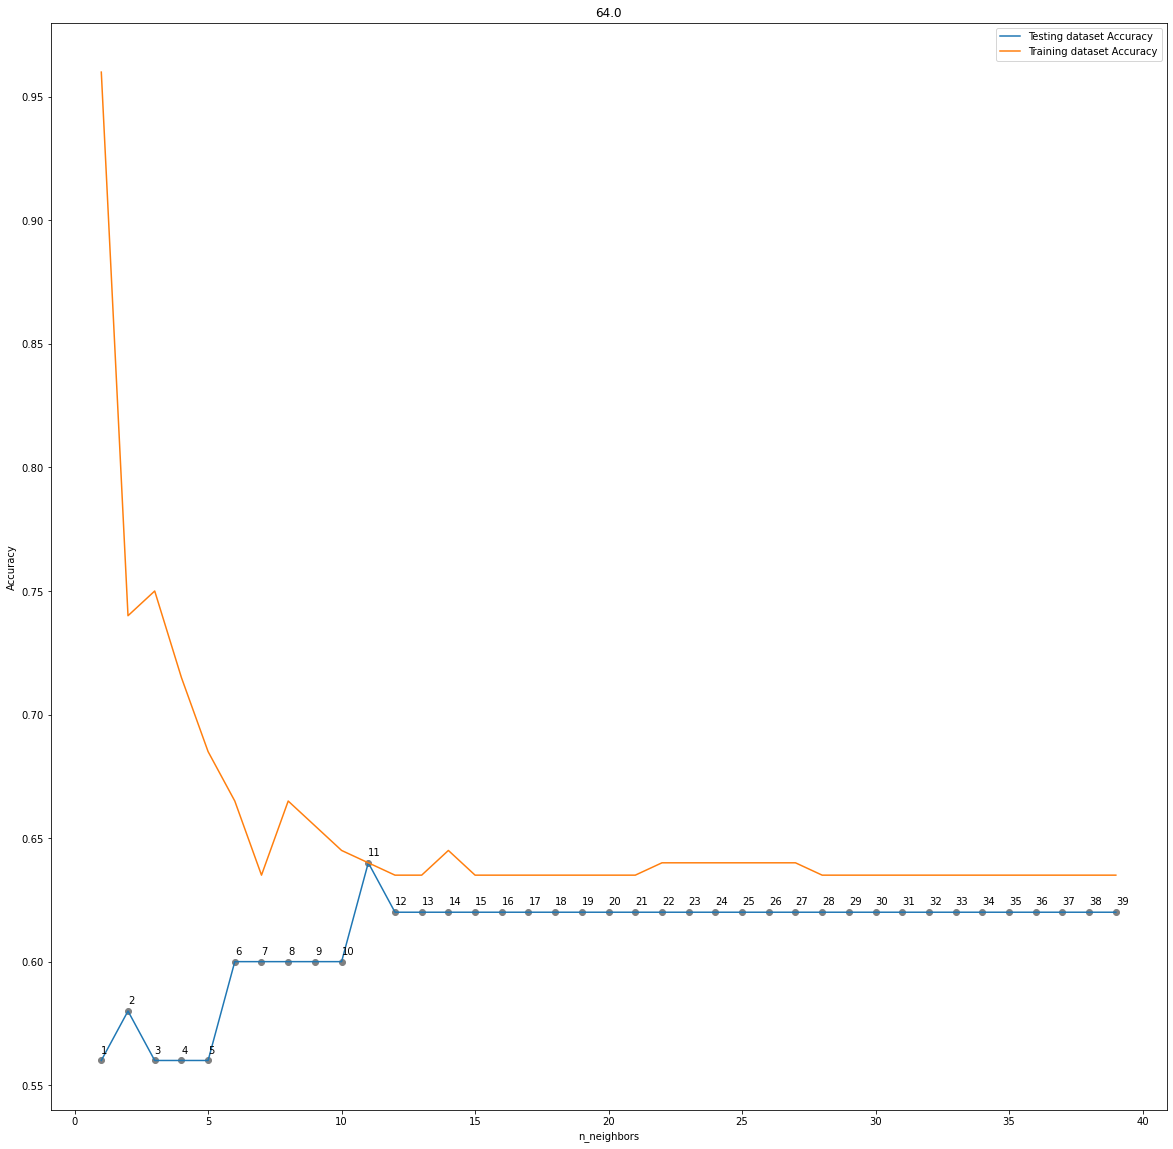

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# init of the tunning 
neighbors = range(1,40)
train_acc = np.empty(len(neighbors))
test_acc = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    # on train sur sub, recall sub vient du backward features selection
    knn.fit(X_train, bmi_train)

    # array that contains acc_score of both samples
    train_acc[i] = knn.score(X_train, bmi_train)
    test_acc[i] = knn.score(X_test, bmi_test)

plt.plot(neighbors, test_acc, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_acc, label = 'Training dataset Accuracy')
for k, acc in enumerate(test_acc):
    plt.text(k+1, acc+0.003, k+1)
    plt.scatter(k+1,acc, c = 'grey')
 
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.title(max(test_acc)*100)
plt.show()

## Full Model 

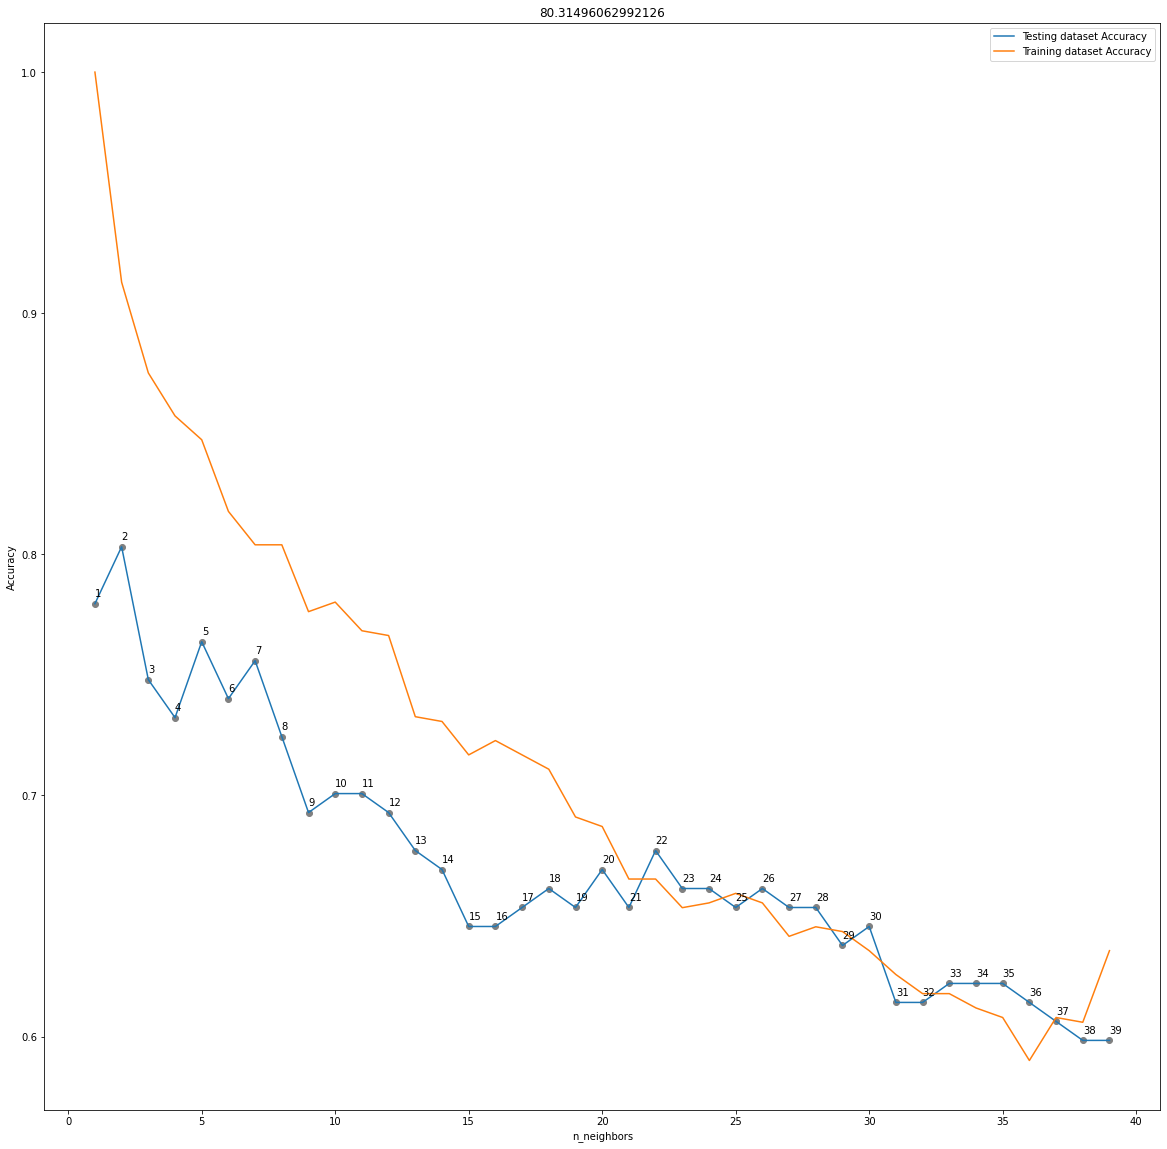

In [ ]:
X_train, X_test, bmi_train, bmi_test = train_test_split(X_res, bmi_res, test_size=0.2, shuffle=True)

# init of the tunning 
neighbors = range(1,40)
train_acc = np.empty(len(neighbors))
test_acc = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    # on train sur sub, recall sub vient du backward features selection
    knn.fit(X_train, bmi_train)

    # array that contains acc_score of both samples
    train_acc[i] = knn.score(X_train, bmi_train)
    test_acc[i] = knn.score(X_test, bmi_test)

plt.plot(neighbors, test_acc, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_acc, label = 'Training dataset Accuracy')
for k, acc in enumerate(test_acc):
    plt.text(k+1, acc+0.003, k+1)
    plt.scatter(k+1,acc, c = 'grey')
 
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.title(max(test_acc)*100)
plt.show()

## KNN MC

In [ ]:
# init param
n_it = range(1,100)
n_neighbor_max = range(1,40)
total_best_test_acc = np.empty(len(n_it))
best_k_values = np.empty(len(n_it))

# loop
for i,it in enumerate(n_it):

    X_train, X_test, bmi_train, bmi_test = train_test_split(X_res, bmi_res, test_size=0.3, shuffle=True)

    train_acc = np.empty(len(n_neighbor_max))
    test_acc = np.empty(len(n_neighbor_max))

    for j,k in enumerate(n_neighbor_max):
        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(X_train, bmi_train)

        train_acc[j] = knn.score(X_train, bmi_train)
        test_acc[j] = knn.score(X_test, bmi_test)
    
    total_best_test_acc[i] = np.max(test_acc)
    best_k_values[i] = np.argmax(test_acc)

    

print(np.mean(total_best_test_acc))
print(np.round(np.mean(best_k_values)))

0.8059542796384901
1.0


# Random Forest

In [ ]:
X_train, X_test, bmi_train, bmi_test = train_test_split(X_res, bmi_res, test_size=0.3, shuffle=True)

svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, bmi_train)

svclassifier.score(X_test, bmi_test)

0.8263157894736842

# LinReg + MLP 

In [ ]:
# calcul de la mean error pour chaque prediction

v_error = np.empty((10000,250))

for i, it in enumerate(range(1,10000)):

    X_train, X_test, y_train, y_test = train_test_split(X_cleaned_bmi, y_1, test_size=0.3)
    # fit the model 
    model = LinearRegression().fit(X_train,y_train)

    # predict 
    y_pred = model.predict(X_cleaned_bmi)

    # error 
    y_error = np.array(np.abs(y_1-y_pred)).ravel()

    v_error[i] = y_error
    

mean_error = np.mean(v_error, axis=0)
mean_error

array([8.65420314e+00, 1.47820582e+01, 1.53293862e+01, 1.48665317e+01,
       5.60781635e+00, 1.09417566e+01, 4.95928629e+00, 8.10434905e+00,
       1.48140160e+01, 1.31466377e+01, 6.36182935e+00, 6.58148783e+00,
       1.29962992e+01, 1.66832591e+01, 1.08986790e+01, 6.05314353e+00,
       1.29359284e+01, 6.58150986e+00, 9.35464880e+00, 7.65431047e+00,
       1.35502203e+01, 8.90939401e+00, 8.41405750e+00, 6.65042848e+00,
       5.21883751e+00, 1.19678535e+01, 8.66768622e+01, 9.33461425e+00,
       1.13673444e+01, 2.44266283e+11, 4.88164092e+00, 9.70699578e+00,
       8.11457860e+00, 1.54970970e+01, 9.49461946e+00, 6.45528547e+00,
       2.74370814e+01, 1.20586634e+01, 5.82927487e+00, 2.63811722e+01,
       2.06036765e+01, 1.55253851e+01, 6.11082529e+00, 1.13694165e+01,
       2.44266283e+11, 7.84919308e+00, 1.07201373e+01, 2.43471608e+11,
       1.17218036e+01, 6.96707635e+00, 5.23846365e+00, 6.72188613e+00,
       5.69770819e+00, 1.04038188e+01, 5.37376908e+00, 8.82250016e+00,
      

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_1_cleaned, mean_error, test_size=0.3)

In [ ]:
def mlp_model(X, Y):

    estimator= MLPRegressor(max_iter=5000)
    
    param_grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,1)],
        'activation': ['relu','identity'],
        'alpha': [0.0001, 0.05],
        #'learning_rate': ['constant','adaptive'],
        'solver': ['lbfgs', 'adam']}

    gsc = GridSearchCV(
        estimator,
        param_grid,
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    grid_result = gsc.fit(X, Y)
    best_params = grid_result.best_params_

    """
    best_mlp = MLPRegressor(hidden_layer_sizes = best_params["hidden_layer_sizes"], 
                            activation =best_params["activation"],
                            solver=best_params["solver"],
                            max_iter= 5000, n_iter_no_change = 200)
    
    scoring = {
            'abs_error': 'neg_mean_absolute_error',
            'squared_error': 'neg_mean_squared_error',
            'r2':'r2'}

    scores = cross_validate(best_mlp, X, Y, cv=10, scoring=scoring, return_train_score=True, return_estimator = True)"""

    return best_params

In [ ]:
print(mlp_model(X_train, y_train))

{'activation': 'identity', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'solver': 'lbfgs'}


In [ ]:
best_mlp = MLPRegressor(hidden_layer_sizes =(50,100, 50), 
                        activation ='identity',
                        solver='adam',
                        max_iter= 5000, 
                        n_iter_no_change = 200,
                        alpha = 0.05).fit(X_train, y_train)
print(best_mlp.score(X_test, y_test))